# Dask DataFrames

In this notebook we demonstrate how to work with dask dataframes. 

* A few words about dask dataframes
* Weather station data
* Tuning read_csv
* Compute using dask.dataframe
* Write to Parquet for better performance
* Read Parquet to compare
* More calculation exercises
* Dask.dataframe vs. Pandas

-----


- Authors: NCI Virtual Research Environment Team
- Keywords: Dask, Dataframe, csv, partition
- Create Date: 2020-May
- Lineage/Reference: This tutorial is referenced to [dask-tutorial](https://github.com/dask/dask-tutorial)
----


## Dask DataFrames

In the previous tutorial, we built a parallel dataframe computation over a directory of Paleoceanography CSV files with `dask.delayed`. We now use `dask.dataframe` to automatically build similiar computations for the common case of tabular computations. Dask dataframes look and feel like Pandas dataframes but they run on the same infrastructure that powers `dask.delayed`.

#### Dask DataFrame Data Model

So far, the biggest difference we've seen is that Dask operations are lazy; they build up a task graph instead of executing immediately.
This lets Dask do operations in parallel and out of core.

In the Dask array example, we saw that a `dask.array` was composed of many NumPy arrays, chunked along one or more dimensions. It's similar for `dask.dataframe`: a Dask DataFrame is composed of many pandas DataFrames. For `dask.dataframe` the chunking happens only along the index.

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="30%">

We call each chunk a *partition*, and the upper / lower bounds are *divisions*.
Dask can store information about the divisions. You can operate on dataframe per partition at a time when you write custom functions to apply to Dask DataFrames.

The `dask.dataframe` module implements a blocked parallel `DataFrame` object that mimics a large subset of the Pandas `DataFrame`. One Dask `DataFrame` is comprised of many in-memory Pandas `DataFrames` separated along the index. One operation on a Dask `DataFrame` triggers many Pandas operations on the constituent Pandas `DataFrame` in a way that is mindful of potential parallelism and memory constraints.

**Main take-aways**

1.  Dask DataFrame will be familiar to Pandas users
2.  The partitioning of dataframes is important for efficient execution

#### When to use `dask.dataframe`

In this notebook we use the weather stations within 50km of Acton, ACT. The data can be downloaded from [the Australian Bureau of Meterology climate data service site](http://www.bom.gov.au/climate/data/stations/). Rather than writing for-loops, we let `dask.dataframe` construct our computations. The `dask.dataframe.read_csv` function can take a globstring like `"data/weather_stations_ACT/*.csv"` and build parallel computations on all of our data at once.

Pandas is great for tabular datasets that fit in memory. Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM. The demo dataset we're working with is only about 65MB, so that you can download it in a reasonable time, but `dask.dataframe` will scale to datasets much larger than memory.

### Set up

Choose from the following two options to create a client:

In [41]:
# If you run this notebook on your local computer or NCI's VDI instance, you can create cluster
from dask.distributed import Client
client = Client()
print(client)

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38957 instead
  http_address["port"], self.http_server.port


<Client: 'tcp://127.0.0.1:40805' processes=4 threads=8, memory=33.56 GB>


In [ ]:
# If you run this notebook on Gadi under pangeo environment, you can create cluster using scheduler.json file
from dask.distributed import Client, LocalCluster
client = Client(scheduler_file='../scheduler.json')
print(client)

<div class="alert alert-info">
<b>Warning: Please make sure you specify the correct path to the scheduler.json file within your environment.</b>  
</div>

Starting the Dask Client will provide a dashboard which is useful to gain insight into the computation. The link to the dashboard will become visible when you create the Client. We recommend having the Client open on one side of your screen and your notebook open on the other side, which will be useful for learning purposes.

### Weather station data

In [6]:
import os
import dask
# Provide path to where you have saved the BoM data
filename = os.path.join('/g/data/dk92/notebooks/demo_data/Weather_Stations_ACT','IDCJAC0009_*_*','IDCJAC0009*.csv')
filename

'/g/data/dk92/notebooks/demo_data/Weather_Stations_ACT/IDCJAC0009_*_*/IDCJAC0009*.csv'

Filename includes a glob pattern `*`, so all files in the path matching that pattern will be read into the same Dask DataFrame.

We can read one file with `pandas.read_csv` or many files with `dask.dataframe.read_csv`

In [7]:
import pandas as pd
df = pd.read_csv('/g/data/dk92/notebooks/demo_data/Weather_Stations_ACT/IDCJAC0009_042010_2015/IDCJAC0009_042010_2015_Data.csv')
df.head()

Product code  Bureau of Meteorology station number  Year  Month  Day  \
0   IDCJAC0009                                 42010  2015      1    1   
1   IDCJAC0009                                 42010  2015      1    2   
2   IDCJAC0009                                 42010  2015      1    3   
3   IDCJAC0009                                 42010  2015      1    4   
4   IDCJAC0009                                 42010  2015      1    5   

   Rainfall amount (millimetres)  \
0                            0.0   
1                           20.0   
2                           15.2   
3                            0.0   
4                            0.0   

   Period over which rainfall was measured (days) Quality  
0                                             NaN       Y  
1                                             1.0       Y  
2                                             1.0       Y  
3                                             NaN       Y  
4                                             NaN       Y

In [8]:
import dask.dataframe as dd
ddf = dd.read_csv(filename)
ddf

Dask DataFrame Structure:
                Product code Bureau of Meteorology station number   Year  Month    Day Rainfall amount (millimetres) Period over which rainfall was measured (days) Quality
npartitions=125                                                                                                                                                            
                      object                                int64  int64  int64  int64                       float64                                        float64  object
                         ...                                  ...    ...    ...    ...                           ...                                            ...     ...
...                      ...                                  ...    ...    ...    ...                           ...                                            ...     ...
                         ...                                  ...    ...    ...    ...                           ...                                            ...     ...
                         ...                                  ...    ...    ...    ...                           ...                                            ...     ...
Dask Name: read-csv, 125 tasks

Notice that the respresentation of the dataframe object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.

Also data dataframe uses "from-delayed" so that 125 tasks are read efficiently into the memory. 

We can view the start and end of the data

In [9]:
ddf.head()

Product code  Bureau of Meteorology station number  Year  Month  Day  \
0   IDCJAC0009                                 42010  2015      1    1   
1   IDCJAC0009                                 42010  2015      1    2   
2   IDCJAC0009                                 42010  2015      1    3   
3   IDCJAC0009                                 42010  2015      1    4   
4   IDCJAC0009                                 42010  2015      1    5   

   Rainfall amount (millimetres)  \
0                            0.0   
1                           20.0   
2                           15.2   
3                            0.0   
4                            0.0   

   Period over which rainfall was measured (days) Quality  
0                                             NaN       Y  
1                                             1.0       Y  
2                                             1.0       Y  
3                                             NaN       Y  
4                                             NaN       Y

In [10]:
ddf.tail() 

Product code  Bureau of Meteorology station number  Year  Month  Day  \
1395   IDCJAC0009                                 73148  2007     10   27   
1396   IDCJAC0009                                 73148  2007     10   28   
1397   IDCJAC0009                                 73148  2007     10   29   
1398   IDCJAC0009                                 73148  2007     10   30   
1399   IDCJAC0009                                 73148  2007     10   31   

      Rainfall amount (millimetres)  \
1395                           12.5   
1396                            1.0   
1397                           10.4   
1398                            0.0   
1399                            0.0   

      Period over which rainfall was measured (days) Quality  
1395                                             3.0       Y  
1396                                             1.0       Y  
1397                                             1.0       Y  
1398                                             NaN       Y  
1399                                             NaN       Y

In [11]:
# load and count number of rows
len(ddf)

1754661

What happened here?
- Dask investigated the input path and found all 125 matching files (see **npartitions=125**)
- a set of jobs was intelligently created for each chunk - one per original CSV file in this case
- each file was loaded into a pandas dataframe, had `len()` applied to it
- the subtotals were combined to produce the final total.

### Tuning read_csv

The Pandas `read_csv` function has many options to help you parse files. The Dask version uses the Pandas function internally, and so supports many of the same options. You can use the `?` operator to see the full documentation string.

In [12]:
pd.read_csv?

In this case we use the `parse_dates` keyword to parse the timestamp column to be a datetime. This will make things more efficient in the future. Notice that the dtype of the timestamp column has changed from `object` to `datetime64[ns]`.

Unlike `pandas.read_csv` which reads in the entire file before inferring data types, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using **glob**). These inferred data types are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The `Bureau of Meteorology station number` should be strings (`object` dtype), rather than integers. Note that Dask gives an informative error message about the mismatch. We can fix this by directly specifying the `dtypes` of the offending columns. 

## Computations with `dask.dataframe`

We compute the maximum of the `Rainfall amount (millimetres)` column. With just Pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums

```python
from glob import glob

maxes = []
filenames = sorted(glob('/g/data/dk92/notebooks/demo_data/Weather_Stations_ACT/IDCJAC0009_*_*/IDCJAC0009*.csv'))
for fn in filenames:
    with pd.read_csv(fn) as df:
        # rename column names to shorter strings
        df.columns = ['code','station','year','month','day','rainfall','period','quality']
        maxes.append(df.rainfall.max())
    
final_max = max(maxes)
```

We could wrap that `pd.read_csv` with `dask.delayed` so that it runs in parallel. Regardless, we're still having to think about loops, intermediate results (one per file) and the final reduction (`max` of the intermediate maxes). This is just noise around the real task, which Pandas solves with

```python
df.rainfall.max()
```

`dask.dataframe` lets us write pandas-like code that operates on larger than memory datasets in parallel.

**Compare the runtime of the following two blocks of code:**

In [13]:
%%time

from glob import glob

maxes = []
filenames = sorted(glob('/g/data/dk92/notebooks/demo_data/Weather_Stations_ACT/IDCJAC0009_*_*/IDCJAC0009*.csv'))

for fn in filenames:
    df = pd.read_csv(fn)
    # rename column names to shorter strings
    df.columns = ['code','station','year','month','day','rainfall','period','quality']
    maxes.append(df.rainfall.max())
    
final_max = max(maxes)

print(final_max)

322.1
CPU times: user 1.44 s, sys: 439 ms, total: 1.88 s
Wall time: 1.92 s


In [14]:
ddf.columns = ['code','station','year','month','day','rainfall','period','quality']
%time ddf.rainfall.max().compute()

CPU times: user 382 ms, sys: 30.5 ms, total: 412 ms
Wall time: 937 ms


322.1

This writes the delayed computation for us and then runs it.  

Some things to note:

1.  As with `dask.delayed`, we need to call `.compute()` when we're done.  Up until this point everything is lazy.
2.  Dask will delete intermediate results (like the full pandas dataframe for each file) as soon as possible.
    -  This lets us handle datasets that are larger than memory
    -  This means that repeated computations will have to load all of the data in each time (run the code above again, is it faster or slower than you would expect?)
    
As with `Delayed` objects, you can view the underlying task graph using the `.visualize` method:

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.964104 to fit


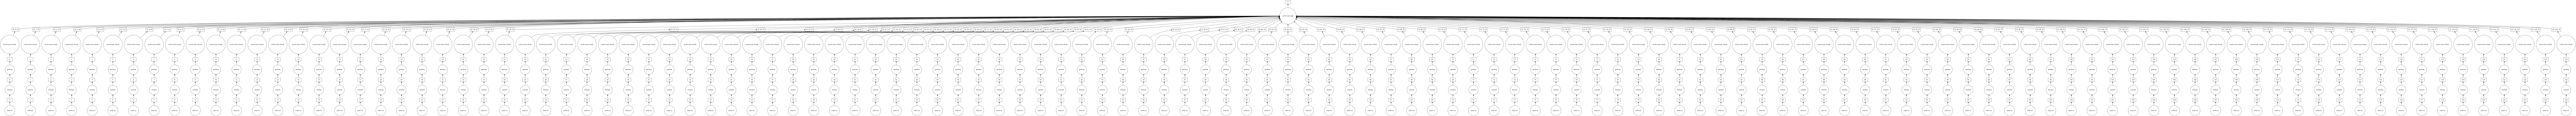

In [18]:
# notice the parallelism
ddf.rainfall.max().visualize()

### Write to Parquet

Whenever we operate on our dataframe we read through all of our CSV data so that we don’t fill up RAM. This is very efficient for memory use, but reading through all of the CSV files every time can be slow.

Instead, we’ll store our data in Parquet, a binary format that is more efficient for computers to read and write. Parquet stores nested data structures in a flat columnar format. Compared to the traditional row-oriented storage approach, Parquet is more efficient in terms of storage and performance.

In [11]:
# Please change /g/data/dk92/data/ACT_weather.parquet to a directory you have write permissions to 
ddf.to_parquet('/g/data/dk92/notebooks/demo_data/ACT_weather.parquet', engine='pyarrow')

/g/data/dk92/packages/pyarrow/compat.py:25: FutureWarning: pyarrow.compat has been deprecated and will be removed in a future release
  "future release", FutureWarning)


In [12]:
!ls /g/data/dk92/notebooks/demo_data/ACT_weather.parquet 

_common_metadata  part.14.parquet  part.43.parquet  part.72.parquet
_metadata	  part.15.parquet  part.44.parquet  part.73.parquet
part.0.parquet	  part.16.parquet  part.45.parquet  part.74.parquet
part.100.parquet  part.17.parquet  part.46.parquet  part.75.parquet
part.101.parquet  part.18.parquet  part.47.parquet  part.76.parquet
part.102.parquet  part.19.parquet  part.48.parquet  part.77.parquet
part.103.parquet  part.1.parquet   part.49.parquet  part.78.parquet
part.104.parquet  part.20.parquet  part.4.parquet   part.79.parquet
part.105.parquet  part.21.parquet  part.50.parquet  part.7.parquet
part.106.parquet  part.22.parquet  part.51.parquet  part.80.parquet
part.107.parquet  part.23.parquet  part.52.parquet  part.81.parquet
part.108.parquet  part.24.parquet  part.53.parquet  part.82.parquet
part.109.parquet  part.25.parquet  part.54.parquet  part.83.parquet
part.10.parquet   part.26.parquet  part.55.parquet  part.84.parquet
part.110.parquet  part.27.parquet  part.56.parquet  part

### Read from Parquet

In [13]:
%%time 
new_df = pd.read_parquet('/g/data/dk92/notebooks/demo_data/ACT_weather.parquet', engine='pyarrow')
new_df.rainfall.max()

CPU times: user 592 ms, sys: 261 ms, total: 853 ms
Wall time: 777 ms


322.1

#### Select only the columns that you plan to use

Parquet is a column-store, which means that it can efficiently pull out the columns of interest from your dataset. This is useful as it helps to avoid unnecessary data loading.

In [14]:
%%time
new_df = pd.read_parquet('/g/data/dk92/notebooks/demo_data/ACT_weather.parquet', columns=['rainfall'], engine='pyarrow')
new_df.rainfall.max()

CPU times: user 349 ms, sys: 50.5 ms, total: 400 ms
Wall time: 382 ms


322.1

## Exercises

In this section we do a few `dask.dataframe` computations. These should be familiar to you if you are comfortable with Pandas. You will have to think about when to call `compute()`.

### 1.) How many rows are in our dataset?

If you aren't familiar with Pandas, how would you check how many records are in a list of tuples?

In [15]:
len(ddf)

1754661

### 2.) In total, how many days records were taken?

*Hint*: `count()` counts non-NaN values.

In [16]:
period = pd.read_parquet('/g/data/dk92/notebooks/demo_data/ACT_weather.parquet', columns=['period'], engine='pyarrow')
period.count()

period    418018
dtype: int64

### 3.) In total, how many non-record days are there from each weather station?

*Hint*: use [`df.groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

In [17]:
ddf.groupby("station").period.count().compute()

station
42010       41
70000    10222
70011    11574
70014     8377
70015     6168
         ...  
70354     1010
71073     4099
72011     2606
72157      377
73148      243
Name: period, Length: 125, dtype: int64

### 4.) What was the average rainfall at each station?

In [18]:
ddf.groupby("station").rainfall.mean().compute()

station
42010    1.372022
70000    1.767808
70011    1.760142
70014    1.689061
70015    1.791328
           ...   
70354    1.790016
71073    2.526155
72011    2.510485
72157    2.541190
73148    1.709147
Name: rainfall, Length: 125, dtype: float64

## Sharing Intermediate Results

When computing all of the above, we sometimes performed the same operation more than once. For most operations, `dask.dataframe` hashes the arguments allowing duplicate computations to be shared and only computed once.

For example, let's compute the mean and standard deviation for all station rainfall. Since Dask operations are lazy, those values aren't the final results but rather the recipe required to obtain these results.

If we compute them with two calls to compute, there is no sharing of intermediate computations.

In [28]:
mean_rainfall= ddf.groupby("station").period.count().mean()
std_rainfall = ddf.groupby("station").period.count().std()

In [29]:
%%time
mean_rainfall_val = mean_rainfall.compute()
std_rainfall_val = std_rainfall.compute()

CPU times: user 901 ms, sys: 83.7 ms, total: 984 ms
Wall time: 2.18 s


Let's try passing both `mean_rainfall` and `std_rainfall` to a single `compute` call.

In [30]:
%%time

mean_rainfall_val, std_rainfall_val = dask.compute(mean_rainfall, std_rainfall)

CPU times: user 646 ms, sys: 68.4 ms, total: 714 ms
Wall time: 1.51 s


Using `dask.compute` takes roughly half the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to dataframe object
- groupby each station
- get the non-value of periods

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function (you may want to use `filename='graph.pdf'` to allow you to zoom in on the graph):

In [34]:
%matplotlib inline
dask.visualize(mean_rainfall,std_rainfall,filename='graph.pdf')

### Close the client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [42]:
client.close()

## How does this compare to Pandas?

Pandas is more mature and fully featured than `dask.dataframe`.  If your data fits in memory then Pandas may be a better option to use.  The `dask.dataframe` module gives you a limited `Pandas` experience when you operate on datasets that don't fit comfortably in memory.

During this tutorial we provide a small dataset consisting of a few CSV files.  This dataset is 65MB on disk, small enough that you would normally use Pandas.

We've chosen this size so that the tutorial exercises finish quickly. Dask.dataframe only really becomes meaningful for problems significantly larger than those presented in this tutorial, when Pandas breaks with the dreaded 

    MemoryError:  ...
    
Furthermore, the distributed scheduler allows the same dataframe expressions to be executed across a cluster. To enable massive "big data" processing, one could execute data ingestion functions such as `read_csv`, where the data is held on storage accessible to every worker node. As most operations begin by selecting only some columns for transforming and filtering, only relatively small amounts of data need to be communicated between machines.

Dask.dataframe operations use `Pandas` operations internally. Generally they run at about the same speed except for the following two cases:

1.  Dask introduces a bit of overhead, around 1ms per task. This is usually negligible.
2.  When Pandas releases the Global Interpreter Lock (GIL - coming to `groupby` in the next version), `dask.dataframe` can call several Pandas operations in parallel within a process, increasing speed somewhat proportional to the number of cores. For operations which don't release the GIL, multiple processes would be needed to obtain the same speedup.

## Limitations

### What doesn't work?

Dask.dataframe only covers a small but well-used portion of the Pandas API.
This limitation is for two reasons:

1.  The Pandas API is **huge**
2.  Some operations are genuinely hard to do in parallel (e.g. sort)

Additionally, some important operations like ``set_index`` work, but are slower
than in Pandas because they include substantial shuffling of data, and may write out to disk.

## Learn More


* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)